# **Analisis Reservas hidrologicas en colombia VS Vertimientos hidricos en colombia y ONI.**

## **Autores:**

- Jhon Alejandro Jaramillo Echeverri
- Juan Sebastián Salazar Luna

## **Objetivo a desarrollar:**

Modelo de regresión quen permita identificar cual es la cantidad volumen de energia (para este caso mensual) en los embalses de Colombia basado en la capacidad neta, los vertimientos de estos, el Oceanic Niño Index (ONI) y la fecha que se analice.

## **Conjuntos de datos**:

- ### ONI (Oceanic Niño Index):

    ##### **Descripción**:

    El Oceanic Niño Index (ONI) es un indicador climático utilizado para monitorear y clasificar los eventos del fenómeno de El Niño y La Niña. Este índice se calcula como la anomalía (desviación) de la temperatura superficial del mar (TSM) en la región central del Pacífico ecuatorial, específicamente en la zona denominada Niño 3.4 (ubicada entre 5°N–5°S y 120°–170°O).

    ![alt text](https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/enso_update/sstanim.gif)

    El ONI se determina como el promedio móvil de tres meses de las anomalías de TSM respecto a un valor climatológico de referencia. Según la magnitud y persistencia de estas anomalías, se identifica si hay:

    - El Niño: ONI ≥ +0.5 °C durante al menos cinco trimestres móviles consecutivos.

    - La Niña: ONI ≤ –0.5 °C durante el mismo período.

    - Condición Neutra: ONI entre –0.5 °C y +0.5 °C.

    ##### **Origen de datos**:

    - Url Web: [Descripción del conjunto de datos](https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php)
    - Url Datos: [Datos historicos ONI](https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt)

    ##### **Columnas**:

    | Columna | Descripción |
    |---------|-------------|
    | SEAS   | Iniciales de los tres meses de los que se esta realizando el promedio de los datos. |
    | YR     | Año |
    | TOTAL     | temperatura superficial del mar (SST). |
    | ANOM     | Valor del Oceanic Niño Index (anomalía de la temperatura superficial del mar). |

- #### Reservas hidraulicas en energia:

    ##### **Descripción**:

    Volumen útil diario y total de los embalses expresados en energía que se utilizan para generación de energía en el Sistema Interconectado nacional reportados de acuerdo con lo establecido en la Resolución CREG 025 de 1995.

    ##### **Origen de datos**:

    - Url Web: [Descripción del conjunto de datos](https://www.simem.co/datadetail/B0E93334-D812-42A7-94FC-3F100BCE7038)
    - Url Datos: [Datos historicos ONI](https://www.simem.co/backend-files/api/PublicData?startDate={start_date}&enddate={end_date}&datasetId=B0E933)

    **Nota:** Solo se puede extraer información mesual. 

    ##### **Columnas**:

    | Columna | Descripción |
    |---------|-------------|
    | FechaPublicacion   | Fecha de publicación del dato en el SIMEM |
    | CodigoEmbalse     | Código del embalse |
    | RegionHidrologica     | Zona geográfica en la cual se agrupan elementos con características hidrológicas similares. |
    | VolumenUtilDiarioEnergia     | Volúmen Útil Diario del Embalse reportado por el agente expresado en energía |
    | CapacidadUtilEnergia     | Es el máximo volumen que puede ser utilizado para la generación de energía en cada embalse. Corresponde a la diferencia entre el volumen máximo técnico y el volumen mínimo técnico. |
    | VolumenTotalEnergia     | 	Es el volumen máximo que puede almacenarse en un embalse, bajo condiciones normales de operación. Equivale a la suma de los siguientes volúmenes: volumen de embalse muerto, volumen mínimo técnico y volumen útil del embalse |
    | VertimientosEnergia     | Vertimientos reportados expresados en energía |

<h1 align="center"> <b>Cargar librerias:</b></h1>

In [ ]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from scipy import stats
import math

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (

                                RandomForestRegressor
                             )

#Escalar Variables
from sklearn.preprocessing import MinMaxScaler

#Evaluación del modelo
from sklearn.metrics import r2_score
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error


#Creación de modelo
import statsmodels.api as sm

#from sklearn.linear_model import LinearRegression

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Configuración warnings
# ==============================================================================
import warnings
import os
warnings.filterwarnings('ignore')

In [205]:
# Obtener informacion de las reservas hidraulicas
# ==============================================================================
from utils.GetData_SIMEM import get_data_simem

from utils.funciones import multiple_plot, identificar_outliers, eval_model, search_param, plot_param_perf

In [206]:
resultados_modelos = []

<h1 align="center"> <b>Cargar y configurar datos ONI</b>:</h1>

In [207]:
# Obtener datos del ONI (Índice Oceánico de El Niño)
oni_url = 'https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt'
indice_oni = pd.read_csv(oni_url, sep='\s+')

indice_oni.head()

,SEAS,YR,TOTAL,ANOM
0,DJF,1950,24.7200,-1.5300
1,JFM,1950,25.1700,-1.3400
2,FMA,1950,25.7500,-1.1600
3,MAM,1950,26.1200,-1.1800
4,AMJ,1950,26.3200,-1.0700


In [208]:
# Crear un diccionario para mapear las siglas a los números de los meses
seas_to_month = {
    'DJF': 1, 'JFM': 2, 'FMA': 3, 'MAM': 4, 'AMJ': 5, 'MJJ': 6,
    'JJA': 7, 'JAS': 8, 'ASO': 9, 'SON': 10, 'OND': 11, 'NDJ': 12
}

# Crear la nueva columna 'Mes' usando el diccionario
indice_oni['Mes'] = indice_oni['SEAS'].map(seas_to_month)


indice_oni.rename(columns={'YR': 'Year', 'Mes': 'Month', 'TOTAL': 'SST','ANOM':'ONI'}, inplace=True)
# Convertir el año y el mes en una columna de fecha
indice_oni['Fecha'] = pd.to_datetime(indice_oni[['Year', 'Month']].assign(DAY=1))

# Resamplear los datos del ONI a frecuencia mensual
indice_oni.set_index('Fecha', inplace=True)

indice_oni.head()

,SEAS,Year,SST,ONI,Month
Fecha,,,,,
1950-01-01,DJF,1950,24.7200,-1.5300,1
1950-02-01,JFM,1950,25.1700,-1.3400,2
1950-03-01,FMA,1950,25.7500,-1.1600,3
1950-04-01,MAM,1950,26.1200,-1.1800,4
1950-05-01,AMJ,1950,26.3200,-1.0700,5


<h1 align="center"> <b>Cargar y configurar datos Reservas hidraulicas Colombia</b>:</h1>

In [209]:
# Verificar si el archivo existe
file_path = 'Data\\ReservasHidraulicasEnergía.xlsx'
if not os.path.exists(file_path):
    # Si no existe, obtener los datos de las reservas hidrológicas
    get_data_simem()


reservas_hidrologicas = pd.read_excel('Data\ReservasHidraulicasEnergía.xlsx')
reservas_hidrologicas.head()

,FechaPublicacion,Fecha,CodigoEmbalse,RegionHidrologica,VolumenUtilDiarioEnergia,CapacidadUtilEnergia,VolumenTotalEnergia,VertimientosEnergia,Total
0,2023-12-19,2013-01-31,AGREGADO_SIN,Colombia,9132098700,15174371537,10263118000,0.0000,NaN
1,2023-12-19,2013-01-31,PORCE2,Antioquia,5139300,133945086,71858700,0.0000,NaN
2,2023-12-19,2013-01-31,MIEL1,Caldas,149497300,235260926,176276000,0.0000,NaN
3,2023-12-19,2013-01-31,MIRAFLOR,Antioquia,138240800,304387239,154204200,0.0000,NaN
4,2023-12-19,2013-01-31,GUAVIO,Oriente,1016278500,2095258858,1066728600,0.0000,NaN


In [210]:

print(reservas_hidrologicas['RegionHidrologica'].unique())

['Colombia' 'Antioquia' 'Caldas' 'Oriente' 'Centro' 'Valle' 'Caribe']


In [211]:
reservas_hidrologicas_colombia = reservas_hidrologicas[reservas_hidrologicas['RegionHidrologica'] == 'Colombia']
reservas_hidrologicas_colombia.head()

,FechaPublicacion,Fecha,CodigoEmbalse,RegionHidrologica,VolumenUtilDiarioEnergia,CapacidadUtilEnergia,VolumenTotalEnergia,VertimientosEnergia,Total
0,2023-12-19,2013-01-31,AGREGADO_SIN,Colombia,9132098700,15174371537,10263118000,0.0000,NaN
31,2023-12-19,2013-01-30,AGREGADO_SIN,Colombia,9212096600,15174371537,10343116300,0.0000,NaN
61,2023-12-19,2013-01-29,AGREGADO_SIN,Colombia,9290399200,15174371537,10421418500,0.0000,NaN
75,2023-12-19,2013-01-28,AGREGADO_SIN,Colombia,9369462000,15174371537,10500481500,0.0000,NaN
99,2023-12-19,2013-01-27,AGREGADO_SIN,Colombia,9451802800,15174371537,10582822500,0.0000,NaN


<h1 align="center"> <b>Analisis variables hidrologicas:</b></h1>

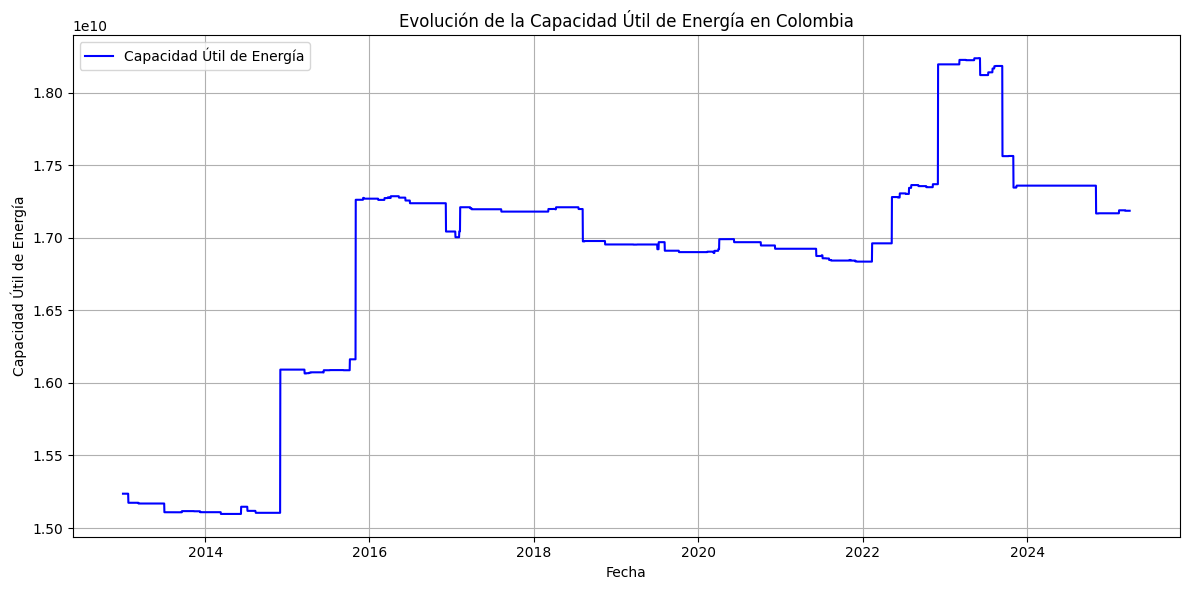

In [212]:
# Asegurar que la columna Fecha esté en formato datetime
reservas_hidrologicas_colombia['Fecha'] = pd.to_datetime(reservas_hidrologicas_colombia['Fecha'])

# Seleccionar solo las columnas numéricas para evitar errores con .mean()
numericas = reservas_hidrologicas_colombia.select_dtypes(include='number')

# Unir las columnas numéricas con la columna Fecha
df_filtrado = pd.concat([reservas_hidrologicas_colombia['Fecha'], numericas], axis=1)

# Agrupar por Fecha y calcular la media de las columnas numéricas
df_agrupado = df_filtrado.groupby('Fecha').mean().reset_index()

# Ordenar por fecha
df_agrupado = df_agrupado.sort_values('Fecha')

# Crear la gráfica
plt.figure(figsize=(12, 6))
plt.plot(df_agrupado['Fecha'],
         df_agrupado['CapacidadUtilEnergia'],
         label='Capacidad Útil de Energía', color='blue')

# Configuración de la gráfica
plt.xlabel('Fecha')
plt.ylabel('Capacidad Útil de Energía')
plt.title('Evolución de la Capacidad Útil de Energía en Colombia')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

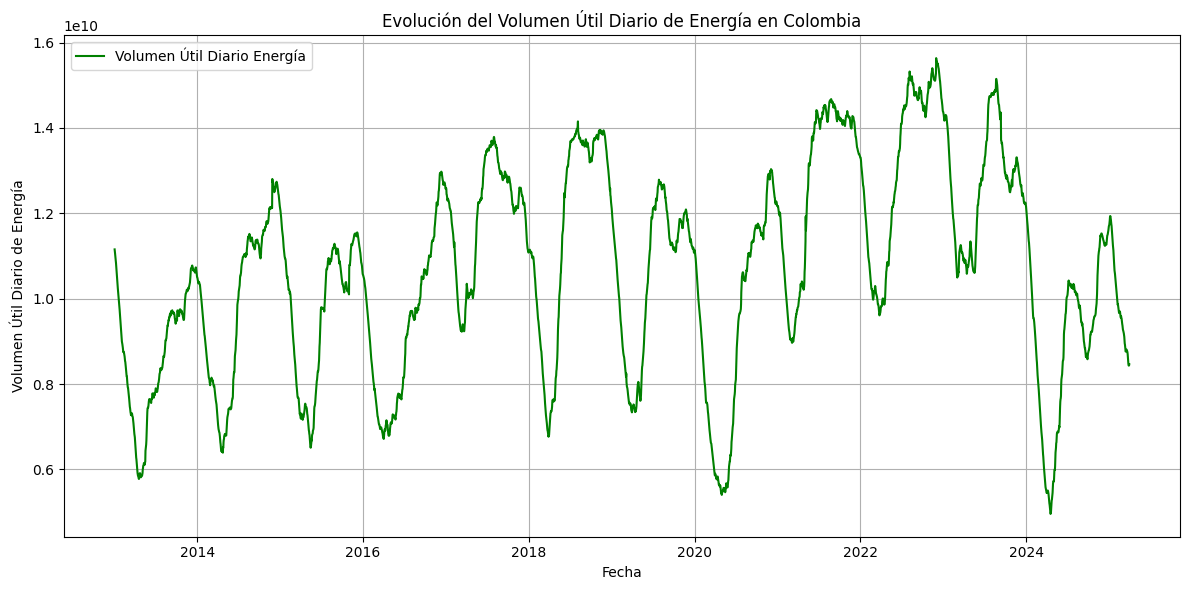

In [213]:
# Asegurar que la columna Fecha esté en formato datetime
reservas_hidrologicas_colombia['Fecha'] = pd.to_datetime(reservas_hidrologicas_colombia['Fecha'])

# Seleccionar solo columnas numéricas
numericas = reservas_hidrologicas_colombia.select_dtypes(include='number')

# Unir Fecha con columnas numéricas
df_filtrado = pd.concat([reservas_hidrologicas_colombia['Fecha'], numericas], axis=1)

# Agrupar por fecha y calcular la media
df_agrupado = df_filtrado.groupby('Fecha').mean().reset_index()

# Ordenar por fecha
df_agrupado = df_agrupado.sort_values('Fecha')

# Crear la gráfica
plt.figure(figsize=(12, 6))
plt.plot(df_agrupado['Fecha'],
         df_agrupado['VolumenUtilDiarioEnergia'],
         label='Volumen Útil Diario Energía', color='green')

# Configuración de la gráfica
plt.xlabel('Fecha')
plt.ylabel('Volumen Útil Diario de Energía')
plt.title('Evolución del Volumen Útil Diario de Energía en Colombia')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

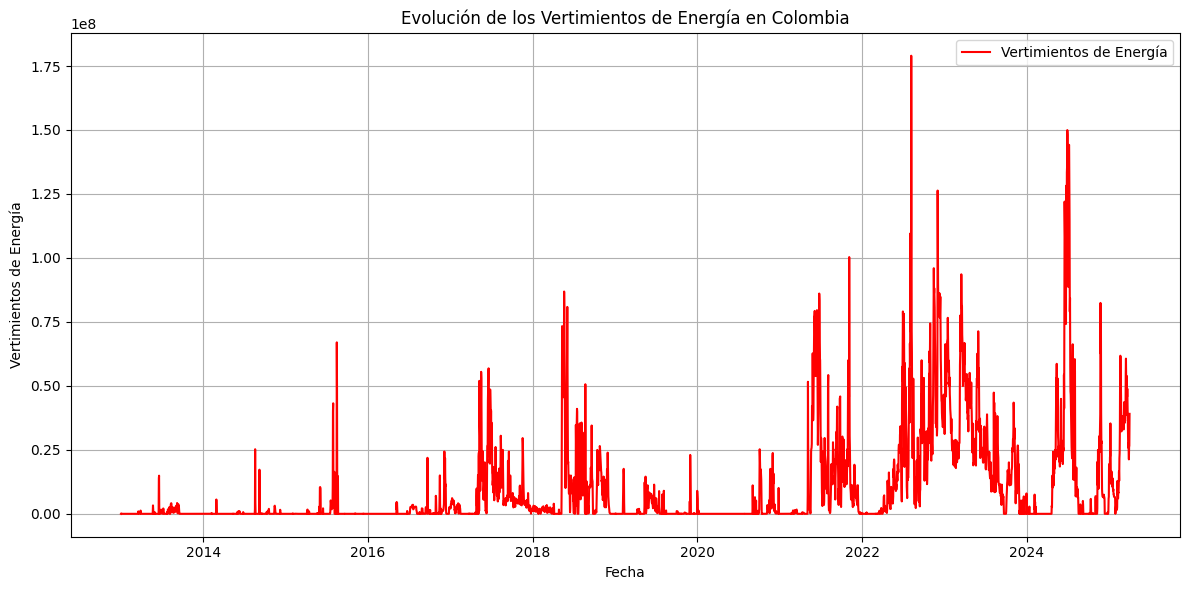

In [214]:
# Asegurar que la columna Fecha esté en formato datetime
reservas_hidrologicas_colombia['Fecha'] = pd.to_datetime(reservas_hidrologicas_colombia['Fecha'])

# Seleccionar solo columnas numéricas
numericas = reservas_hidrologicas_colombia.select_dtypes(include='number')

# Unir Fecha con columnas numéricas
df_filtrado = pd.concat([reservas_hidrologicas_colombia['Fecha'], numericas], axis=1)

# Agrupar por fecha y calcular el promedio
df_agrupado = df_filtrado.groupby('Fecha').mean().reset_index()

# Ordenar por fecha
df_agrupado = df_agrupado.sort_values('Fecha')

# Crear la gráfica
plt.figure(figsize=(12, 6))
plt.plot(df_agrupado['Fecha'],
         df_agrupado['VertimientosEnergia'],
         label='Vertimientos de Energía', color='red')

# Configuración de la gráfica
plt.xlabel('Fecha')
plt.ylabel('Vertimientos de Energía')
plt.title('Evolución de los Vertimientos de Energía en Colombia')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

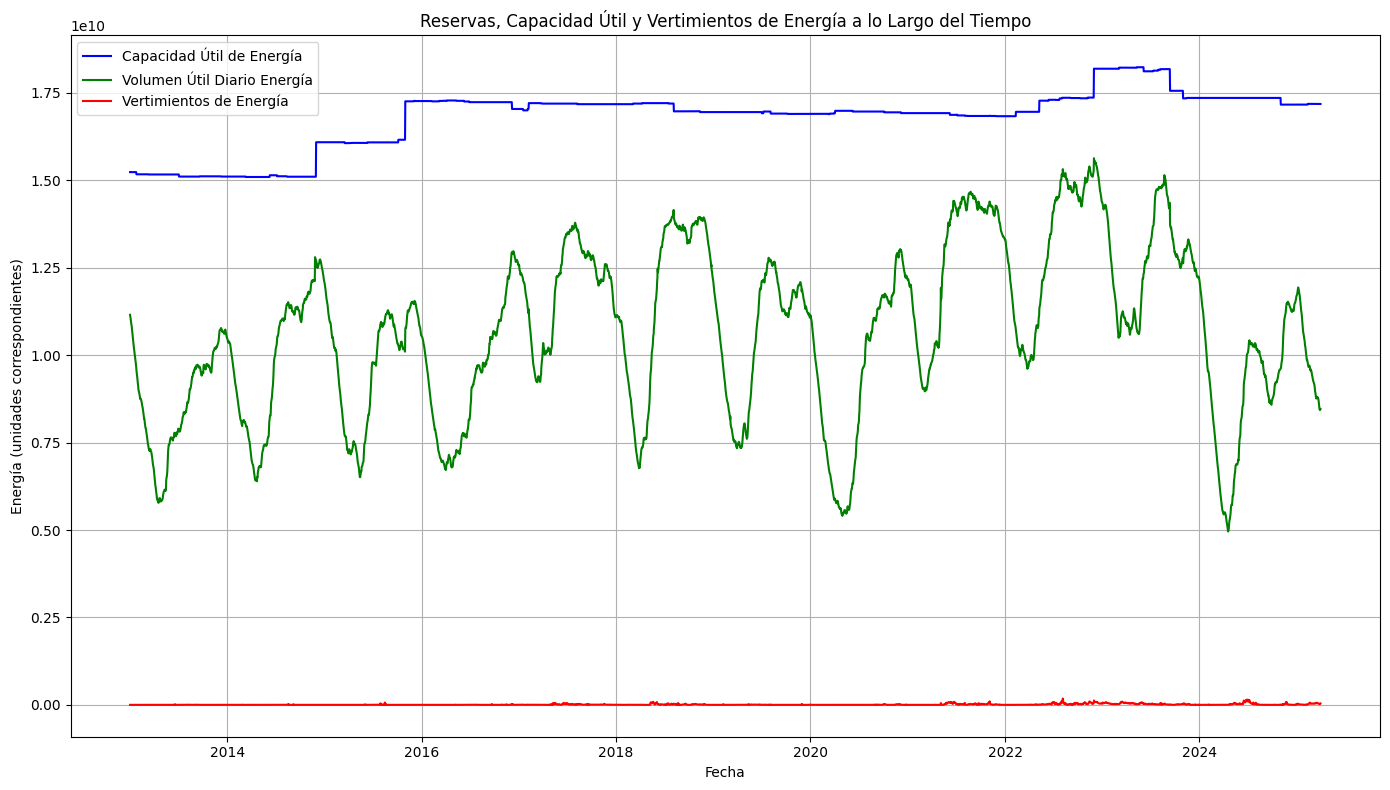

In [215]:
# Asegurar que la columna Fecha esté en formato datetime
reservas_hidrologicas_colombia['Fecha'] = pd.to_datetime(reservas_hidrologicas_colombia['Fecha'])

# Seleccionar solo columnas numéricas
numericas = reservas_hidrologicas_colombia.select_dtypes(include='number')

# Unir Fecha con columnas numéricas
df_filtrado = pd.concat([reservas_hidrologicas_colombia['Fecha'], numericas], axis=1)

# Agrupar por fecha y calcular el promedio
df_agrupado = df_filtrado.groupby('Fecha').mean().reset_index()

# Ordenar por fecha
df_agrupado = df_agrupado.sort_values('Fecha')

# Crear la gráfica combinada
plt.figure(figsize=(14, 8))

# Gráfica de capacidad útil
plt.plot(df_agrupado['Fecha'], df_agrupado['CapacidadUtilEnergia'], label='Capacidad Útil de Energía', color='blue')

# Gráfica de volumen útil diario
plt.plot(df_agrupado['Fecha'], df_agrupado['VolumenUtilDiarioEnergia'], label='Volumen Útil Diario Energía', color='green')

# Gráfica de vertimientos
plt.plot(df_agrupado['Fecha'], df_agrupado['VertimientosEnergia'], label='Vertimientos de Energía', color='red')

# Configuración de la gráfica
plt.xlabel('Fecha')
plt.ylabel('Energía (unidades correspondientes)')
plt.title('Reservas, Capacidad Útil y Vertimientos de Energía a lo Largo del Tiempo')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<h1 align="center"> <b>Analisis ONI:</b></h1>

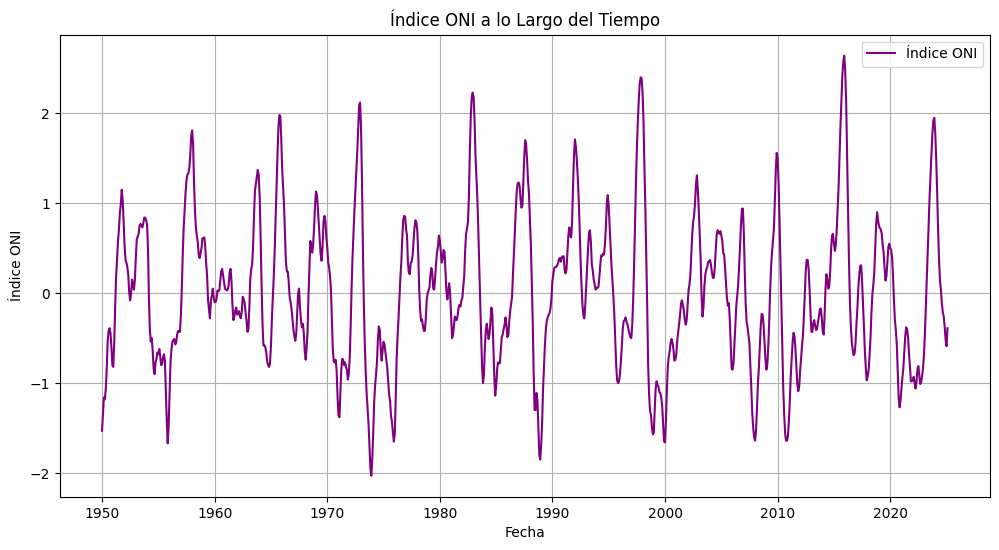

In [216]:
# Crear la gráfica
plt.figure(figsize=(12, 6))
indice_oni.reset_index(inplace=True)  # Colocar temporalmente la fecha como columna
plt.plot(indice_oni['Fecha'], indice_oni['ONI'], label='Índice ONI', color='purple')
plt.xlabel('Fecha')
plt.ylabel('Índice ONI')
plt.title('Índice ONI a lo Largo del Tiempo')
plt.legend()
plt.grid()
plt.show()

<h1 align="center"> <b>Unión de los conjuntos de datos:</b></h1>

In [217]:
# Asegurarse de que la columna Fecha esté en formato datetime
reservas_hidrologicas_colombia['Fecha'] = pd.to_datetime(reservas_hidrologicas_colombia['Fecha'])

# Agrupar por mes y realizar las agregaciones
promedio_volumen_mensual = reservas_hidrologicas_colombia.groupby(reservas_hidrologicas_colombia['Fecha'].dt.to_period('M')).agg({
    'VolumenUtilDiarioEnergia': 'mean',
    'CapacidadUtilEnergia': 'max',
    'VertimientosEnergia': 'sum'
}).reset_index()

# Renombrar la columna 'Fecha' para reflejar que ahora representa el mes
promedio_volumen_mensual.rename(columns={'Fecha': 'Mes'}, inplace=True)

print(promedio_volumen_mensual)

         Mes  VolumenUtilDiarioEnergia  CapacidadUtilEnergia  \
0    2013-01          10188956896.7742           15236874539   
1    2013-02           8546904653.5714           15174371537   
2    2013-03           7318176458.0645           15174371537   
3    2013-04           6018162083.3333           15169264945   
4    2013-05           6546084470.9677           15169264945   
..       ...                       ...                   ...   
142  2024-11          10757701086.6667           17358655983   
143  2024-12          11399685203.2258           17168413107   
144  2025-01          11288462974.1935           17168413107   
145  2025-02           9761608810.7143           17188955397   
146  2025-03           8866162696.7742           17188955397   

     VertimientosEnergia  
0            246965.7600  
1             13410.7206  
2           6182302.1764  
3             82867.7749  
4           5803845.3301  
..                   ...  
142       647339278.7765  
143       11644

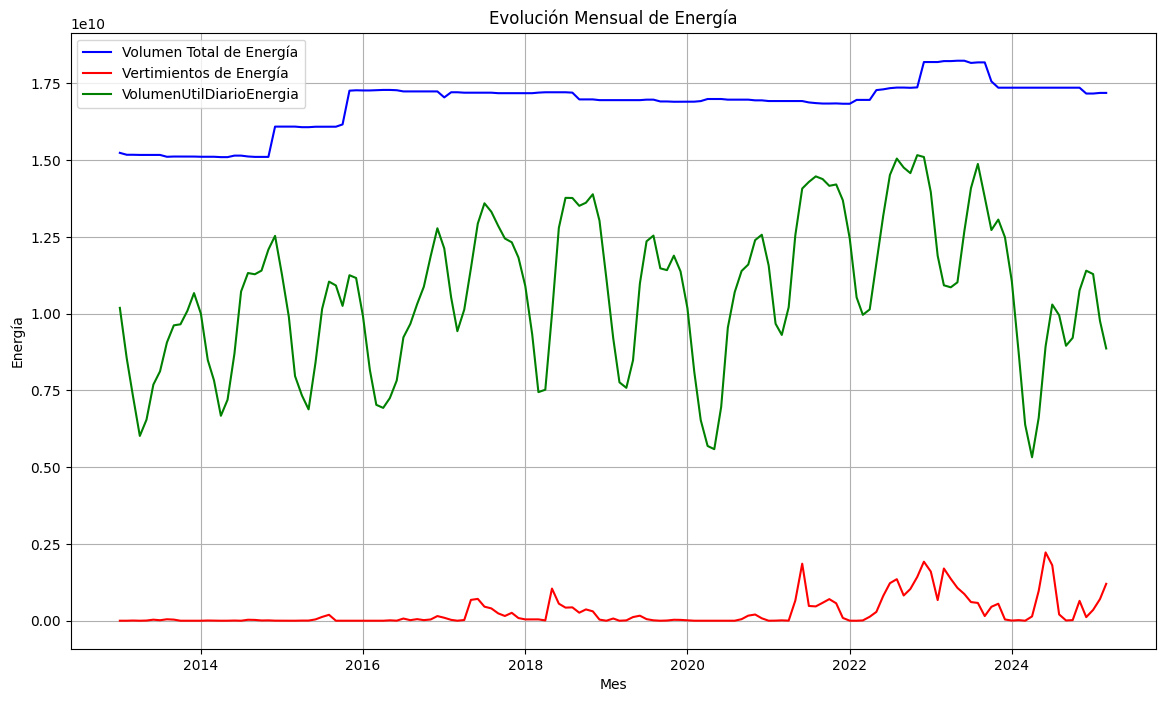

In [218]:
# Convertir la columna 'Mes' a tipo datetime
promedio_volumen_mensual['Mes'] = promedio_volumen_mensual['Mes'].dt.to_timestamp()

# Crear la gráfica
plt.figure(figsize=(14, 8))

# Gráfica de Volumen Total de Energía
plt.plot(promedio_volumen_mensual['Mes'], promedio_volumen_mensual['CapacidadUtilEnergia'], label='Volumen Total de Energía', color='blue')

# Gráfica de Vertimientos de Energía
plt.plot(promedio_volumen_mensual['Mes'], promedio_volumen_mensual['VertimientosEnergia'], label='Vertimientos de Energía', color='red')

# Gráfica de Capacidad Útil de Energía
plt.plot(promedio_volumen_mensual['Mes'], promedio_volumen_mensual['VolumenUtilDiarioEnergia'], label='VolumenUtilDiarioEnergia', color='green')

# Configuración de la gráfica
plt.xlabel('Mes')
plt.ylabel('Energía')
plt.title('Evolución Mensual de Energía')
plt.legend()
plt.grid()
plt.show()


In [219]:
# Asegurarse de que la columna Fecha esté en el formato datetime en ambos DataFrames
promedio_volumen_mensual['Mes'] = pd.to_datetime(promedio_volumen_mensual['Mes'])
indice_oni['Fecha'] = pd.to_datetime(indice_oni['Fecha'])

# Realizar el join entre los DataFrames
data = promedio_volumen_mensual.merge(indice_oni, left_on='Mes', right_on='Fecha', how='inner')

print(data)

           Mes  VolumenUtilDiarioEnergia  CapacidadUtilEnergia  \
0   2013-01-01          10188956896.7742           15236874539   
1   2013-02-01           8546904653.5714           15174371537   
2   2013-03-01           7318176458.0645           15174371537   
3   2013-04-01           6018162083.3333           15169264945   
4   2013-05-01           6546084470.9677           15169264945   
..         ...                       ...                   ...   
141 2024-10-01           9211870938.7097           17358655983   
142 2024-11-01          10757701086.6667           17358655983   
143 2024-12-01          11399685203.2258           17168413107   
144 2025-01-01          11288462974.1935           17168413107   
145 2025-02-01           9761608810.7143           17188955397   

     VertimientosEnergia      Fecha SEAS  Year     SST     ONI  Month  
0            246965.7600 2013-01-01  DJF  2013 26.2100 -0.4300      1  
1             13410.7206 2013-02-01  JFM  2013 26.4400 -0.4300 

In [220]:
data_regretion = data[['ONI', 'SST','CapacidadUtilEnergia', 'VertimientosEnergia','VolumenUtilDiarioEnergia']]

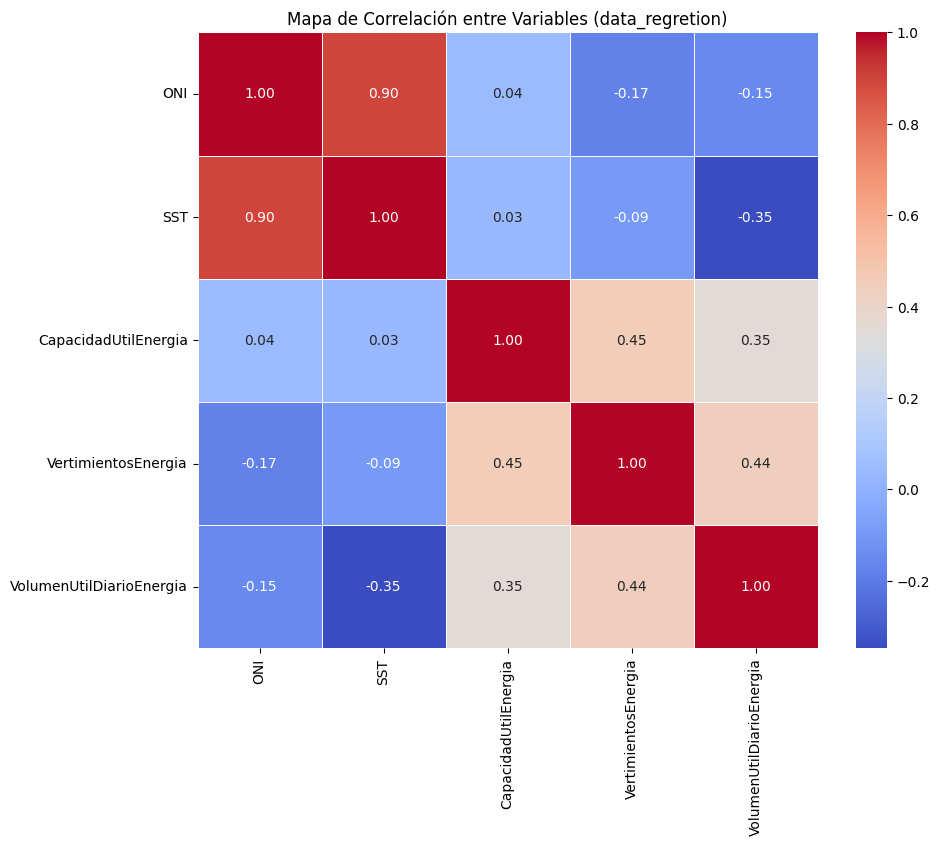

In [221]:


# Calcular la matriz de correlación
correlation_matrix = data_regretion.corr()

# Crear la gráfica de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de Correlación entre Variables (data_regretion)')
plt.show()

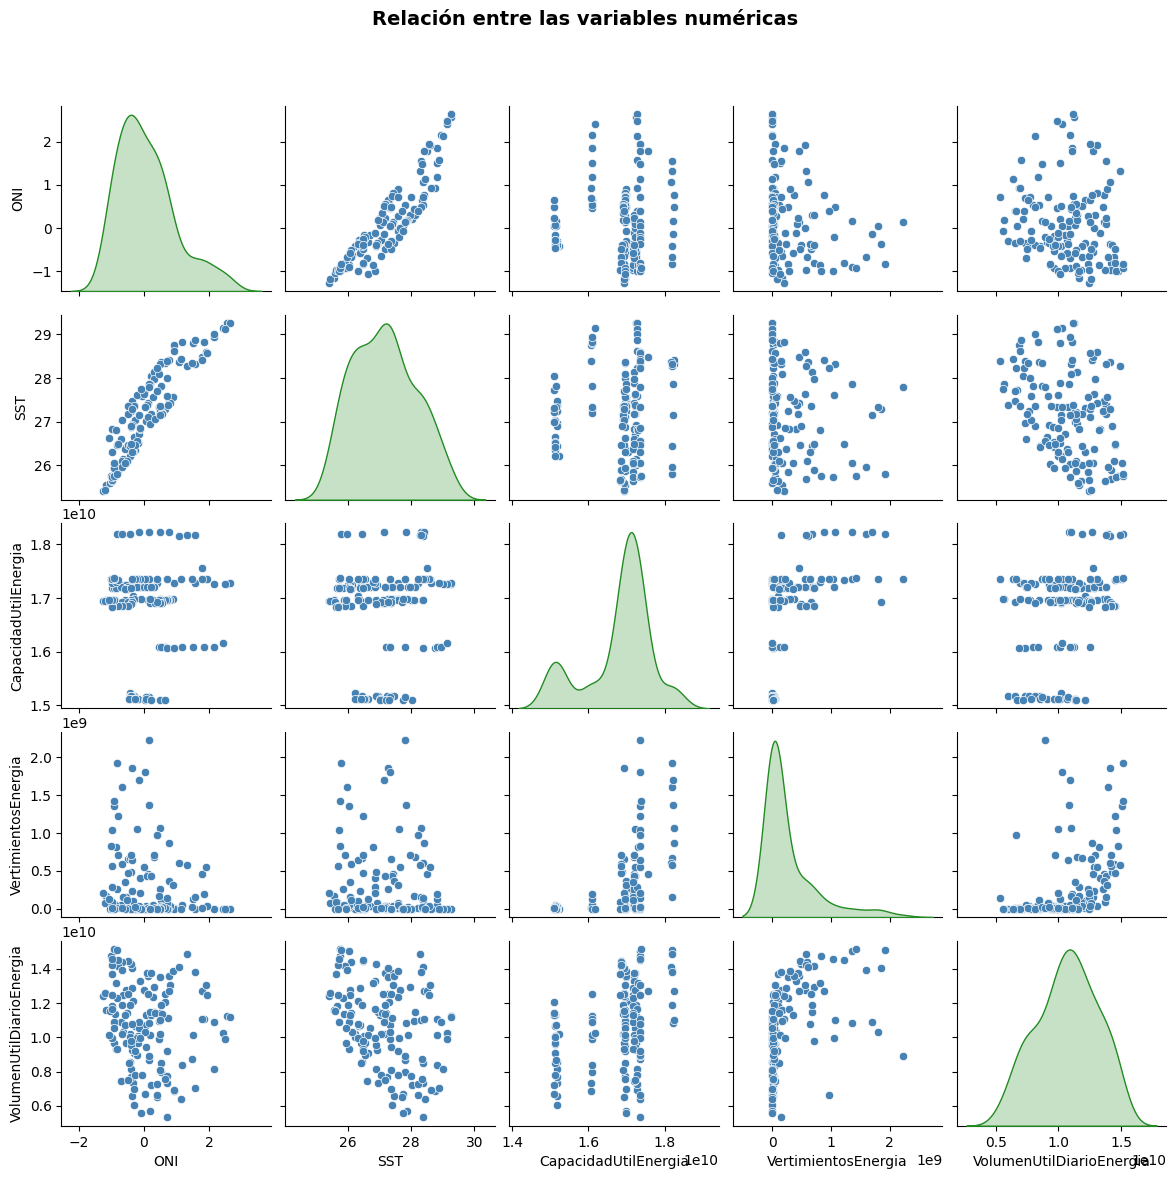

In [222]:
#Visualización de variables numéricas con respecto al precio
multiple_plot(1, data_regretion , data_regretion.select_dtypes(include = ['float64','int32','int64']).columns.tolist(), None, 'scatterplot', 'Relación entre las variables numéricas',30)

In [223]:
# Retirar variables que no son sinificativas

X = data_regretion[['ONI', 'SST','VertimientosEnergia']]
Y = data_regretion['VolumenUtilDiarioEnergia']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        Y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     38.59
Date:                Thu, 01 May 2025   Prob (F-statistic):           1.49e-16
Time:                        18:58:56   Log-Likelihood:                -2312.8
No. Observations:                 102   AIC:                             4634.
Df Residuals:                      98   BIC:                             4644.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.021e+11   1

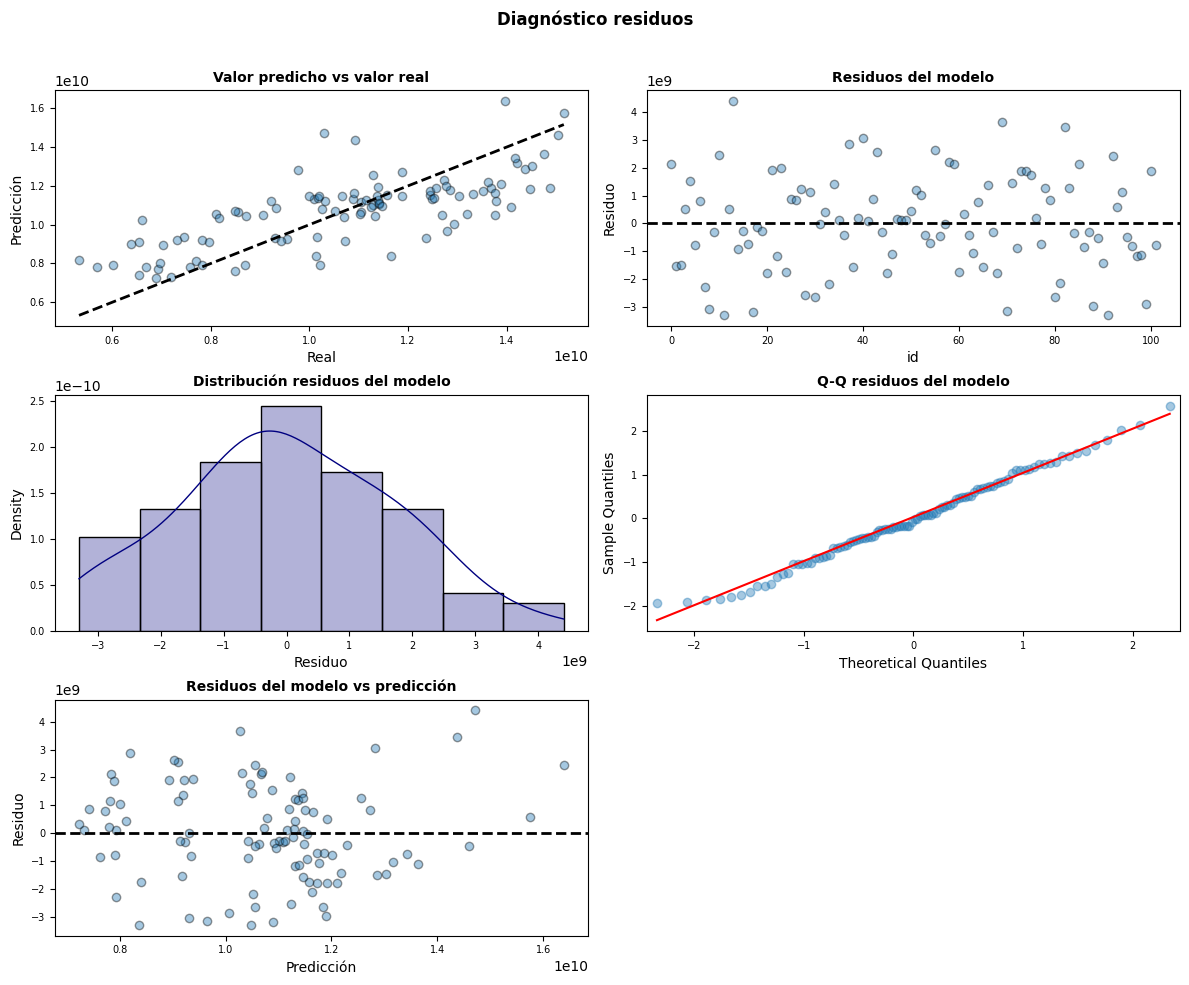

In [224]:
# Diagnóstico errores (residuos) de las predicciones de entrenamiento

#Reducción de dimensionalidad del dataset: se convierte en una dimensión
y_train = y_train.flatten()

#Se realiza la predicción sobre los datos de entrenamiento
prediccion_train = modelo.predict(X_train)

#Se calculan los residuos: diferencia entre la prediccion y el valor real en los datos de entreanamiento 
residuos_train   = prediccion_train - y_train

# Gráficos para el pronóstico de residuos

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                'k--', color = 'black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train))), residuos_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = residuos_train,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color = 'navy', #'firebrick',
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    residuos_train,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'navy', #'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)


axes[2, 0].scatter(prediccion_train, residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
axes[2, 0].set_xlabel('Predicción')
axes[2, 0].set_ylabel('Residuo')
axes[2, 0].tick_params(labelsize = 7)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

<h1 align="center"> <b>Preparacion para modelos de regresión incluyendo la región Hidrologico:</b></h1>

In [225]:
reservas_hidrologicas_region = reservas_hidrologicas[reservas_hidrologicas['RegionHidrologica'] != 'Colombia']
reservas_hidrologicas_region.head()

,FechaPublicacion,Fecha,CodigoEmbalse,RegionHidrologica,VolumenUtilDiarioEnergia,CapacidadUtilEnergia,VolumenTotalEnergia,VertimientosEnergia,Total
1,2023-12-19,2013-01-31,PORCE2,Antioquia,5139300,133945086,71858700,0.0000,NaN
2,2023-12-19,2013-01-31,MIEL1,Caldas,149497300,235260926,176276000,0.0000,NaN
3,2023-12-19,2013-01-31,MIRAFLOR,Antioquia,138240800,304387239,154204200,0.0000,NaN
4,2023-12-19,2013-01-31,GUAVIO,Oriente,1016278500,2095258858,1066728600,0.0000,NaN
5,2023-12-19,2013-01-31,PRADO,Centro,42426200,59469968,86864600,0.0000,NaN


In [226]:
# Convertir la columna 'Fecha' a tipo datetime si no lo es
reservas_hidrologicas_region['Fecha'] = pd.to_datetime(reservas_hidrologicas_region['Fecha'])

promedio_volumen_mensual_region = reservas_hidrologicas_region.groupby(
    [reservas_hidrologicas_region['Fecha'].dt.to_period('M'), 'RegionHidrologica']
).agg({
    'VolumenUtilDiarioEnergia': 'mean',
    'CapacidadUtilEnergia': 'max',
    'VertimientosEnergia': 'sum'
}).reset_index()

promedio_volumen_mensual_region.head()

,Fecha,RegionHidrologica,VolumenUtilDiarioEnergia,CapacidadUtilEnergia,VertimientosEnergia
0,2013-01,Antioquia,418852747.3118,4120023896,246965.7600
1,2013-01,Caldas,160820319.3548,235260926,0.0000
2,2013-01,Caribe,135458400.0000,192324924,0.0000
3,2013-01,Centro,804244987.9032,3992426064,0.0000
4,2013-01,Oriente,886580436.5591,2095258858,0.0000


In [227]:
data =pd.get_dummies(promedio_volumen_mensual_region[['Fecha','CapacidadUtilEnergia', 'VertimientosEnergia','VolumenUtilDiarioEnergia','RegionHidrologica']], drop_first=1)
data.head()

,Fecha,CapacidadUtilEnergia,VertimientosEnergia,VolumenUtilDiarioEnergia,RegionHidrologica_Caldas,RegionHidrologica_Caribe,RegionHidrologica_Centro,RegionHidrologica_Oriente,RegionHidrologica_Valle
0,2013-01,4120023896,246965.7600,418852747.3118,False,False,False,False,False
1,2013-01,235260926,0.0000,160820319.3548,True,False,False,False,False
2,2013-01,192324924,0.0000,135458400.0000,False,True,False,False,False
3,2013-01,3992426064,0.0000,804244987.9032,False,False,True,False,False
4,2013-01,2095258858,0.0000,886580436.5591,False,False,False,True,False


In [228]:
# Asegurarse de que la columna Fecha esté en el formato datetime en ambos DataFrames
data['Fecha'] = pd.to_datetime(data['Fecha'].astype(str) + '-01')
indice_oni['Fecha'] = pd.to_datetime(indice_oni['Fecha'])

# Realizar el join entre los DataFrames
data = data.merge(indice_oni, left_on='Fecha', right_on='Fecha', how='inner')

data.head()

,Fecha,CapacidadUtilEnergia,VertimientosEnergia,VolumenUtilDiarioEnergia,RegionHidrologica_Caldas,RegionHidrologica_Caribe,RegionHidrologica_Centro,RegionHidrologica_Oriente,RegionHidrologica_Valle,SEAS,Year,SST,ONI,Month
0,2013-01-01,4120023896,246965.7600,418852747.3118,False,False,False,False,False,DJF,2013,26.2100,-0.4300,1
1,2013-01-01,235260926,0.0000,160820319.3548,True,False,False,False,False,DJF,2013,26.2100,-0.4300,1
2,2013-01-01,192324924,0.0000,135458400.0000,False,True,False,False,False,DJF,2013,26.2100,-0.4300,1
3,2013-01-01,3992426064,0.0000,804244987.9032,False,False,True,False,False,DJF,2013,26.2100,-0.4300,1
4,2013-01-01,2095258858,0.0000,886580436.5591,False,False,False,True,False,DJF,2013,26.2100,-0.4300,1


In [229]:
# Convertir las columnas booleanas a 1 y 0
columns_to_transform = [
    'RegionHidrologica_Caldas',
    'RegionHidrologica_Caribe',
    'RegionHidrologica_Centro',
    'RegionHidrologica_Oriente',
    'RegionHidrologica_Valle'
]

data[columns_to_transform] = data[columns_to_transform].astype(int)

X = data[[
    'ONI', 'SST','CapacidadUtilEnergia', 
    'VertimientosEnergia',
    'RegionHidrologica_Caldas',
    'RegionHidrologica_Caribe',
    'RegionHidrologica_Centro',
    'RegionHidrologica_Oriente',
    'RegionHidrologica_Valle'
    ]]
Y = data['VolumenUtilDiarioEnergia']

In [230]:
# Convertir la columna 'Fecha' a tipo datetime si no lo es
reservas_hidrologicas_region['Fecha'] = pd.to_datetime(reservas_hidrologicas_region['Fecha'])

promedio_volumen_mensual_region = reservas_hidrologicas_region.groupby(
    [reservas_hidrologicas_region['Fecha'].dt.to_period('M'), 'RegionHidrologica']
).agg({
    'VolumenUtilDiarioEnergia': 'mean',
    'CapacidadUtilEnergia': 'max',
    'VertimientosEnergia': 'sum'
}).reset_index()

promedio_volumen_mensual_region["month"]       = promedio_volumen_mensual_region["Fecha"].dt.month
promedio_volumen_mensual_region["year"]        = promedio_volumen_mensual_region["Fecha"].dt.year

promedio_volumen_mensual_region.head()

# Asegurarse de que la columna Fecha esté en el formato datetime en ambos DataFrames
promedio_volumen_mensual_region['Fecha'] = pd.to_datetime(promedio_volumen_mensual_region['Fecha'].astype(str) + '-01')
indice_oni['Fecha'] = pd.to_datetime(indice_oni['Fecha'])

# Realizar el join entre los DataFrames
# Convertir la columna 'Fecha' a tipo datetime si no lo es
indice_oni['Fecha'] = pd.to_datetime(indice_oni['Fecha'])

# Realizar el join entre los DataFrames
data = promedio_volumen_mensual_region.merge(indice_oni, left_on='Fecha', right_on='Fecha', how='inner')
data =pd.get_dummies(data[['ONI', 'SST','CapacidadUtilEnergia', 'VertimientosEnergia','VolumenUtilDiarioEnergia','RegionHidrologica','month','year']], drop_first=1)
data.head()


,ONI,SST,CapacidadUtilEnergia,VertimientosEnergia,VolumenUtilDiarioEnergia,month,year,RegionHidrologica_Caldas,RegionHidrologica_Caribe,RegionHidrologica_Centro,RegionHidrologica_Oriente,RegionHidrologica_Valle
0,-0.4300,26.2100,4120023896,246965.7600,418852747.3118,1,2013,False,False,False,False,False
1,-0.4300,26.2100,235260926,0.0000,160820319.3548,1,2013,True,False,False,False,False
2,-0.4300,26.2100,192324924,0.0000,135458400.0000,1,2013,False,True,False,False,False
3,-0.4300,26.2100,3992426064,0.0000,804244987.9032,1,2013,False,False,True,False,False
4,-0.4300,26.2100,2095258858,0.0000,886580436.5591,1,2013,False,False,False,True,False


In [231]:
# Convertir las columnas booleanas a 1 y 0
columns_to_transform = [
    'RegionHidrologica_Caldas',
    'RegionHidrologica_Caribe',
    'RegionHidrologica_Centro',
    'RegionHidrologica_Oriente',
    'RegionHidrologica_Valle'
]

data[columns_to_transform] = data[columns_to_transform].astype(int)

X = data[[
    'ONI', 'SST','CapacidadUtilEnergia', 
    'VertimientosEnergia',
    'RegionHidrologica_Caldas',
    'RegionHidrologica_Caribe',
    'RegionHidrologica_Centro',
    'RegionHidrologica_Oriente',
    'RegionHidrologica_Valle',
    'month',
    'year'
    ]]
Y = data['VolumenUtilDiarioEnergia']

In [232]:
# Se definen las fechas de corte para los filtros de la gráfica
cutoff_year_upper = 2022
cutoff_month_upper = 9

# Crear una máscara para los datos de entrenamiento y prueba y aplicar los filtros
train_mask = ((data["year"] < cutoff_year_upper) | 
              ((data["year"] == cutoff_year_upper) & (data["month"] <= cutoff_month_upper)))

test_mask = (data["year"] > cutoff_year_upper) | \
            ((data["year"] == cutoff_year_upper) & (data["month"] > cutoff_month_upper))

#Datos de entrenamiento
data_prueba = data.sample(frac=0.1, random_state=373)

# Separación de variables de entrada y variable de salida
X = data.drop(columns=["VolumenUtilDiarioEnergia"])
y = data["VolumenUtilDiarioEnergia"]

# Crear máscaras para excluir los registros de Xp
exclude_mask = ~data.index.isin(data_prueba.index)

# Filtrar X y y para excluir los registros de Xp
X_filtered = X[exclude_mask]
y_filtered = y[exclude_mask]

# Crear conjuntos de entrenamiento y prueba
X_train = X_filtered[train_mask]
X_test = X_filtered[test_mask]
y_train = y_filtered[train_mask]
y_test = y_filtered[test_mask]

# Escalado de datos
scaler = MinMaxScaler()

# Escalado de datos
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir a dataframes
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Regresión lineal:

In [233]:
# Se crea el modelo de Regresión lineal
lr = LinearRegression()

# Se entrena el modelo
lr.fit(X_train, y_train)

# Evaluación del modelo

lr_model_train_metrics = eval_model(lr, X_train, y_train)
lr_model_train_metrics["name"] = type(lr).__name__ 

lr_model_test_metrics = eval_model(lr, X_test, y_test)
lr_model_test_metrics["name"] = type(lr).__name__

print(lr_model_train_metrics)
print(lr_model_test_metrics)    

{'mae': 87567047.56236, 'rmse': 124174462.80175, 'r2': 0.86488, 'mase': np.float64(0.21491), 'name': 'LinearRegression'}
{'mae': 125450734.965, 'rmse': 197170359.373, 'r2': 0.52159, 'mase': np.float64(0.38595), 'name': 'LinearRegression'}


## Arbol de desición:

In [234]:
# Se crea el modelo de Árbol de decisión
dtr = DecisionTreeRegressor(random_state=3432, max_depth=5)

# Se entrena el modelo
dtr.fit(X_train, y_train)

# Evaluación del modelo

dtr_model_train_metrics = eval_model(dtr, X_train, y_train)
dtr_model_train_metrics["name"] = type(dtr).__name__ 

dtr_model_test_metrics = eval_model(dtr, X_test, y_test)
dtr_model_test_metrics["name"] = type(dtr).__name__

print(dtr_model_train_metrics)
print(dtr_model_test_metrics)

{'mae': 44024023.50303, 'rmse': 64832421.0706, 'r2': 0.96317, 'mase': np.float64(0.10805), 'name': 'DecisionTreeRegressor'}
{'mae': 105040318.0339, 'rmse': 151970338.40676, 'r2': 0.71579, 'mase': np.float64(0.32316), 'name': 'DecisionTreeRegressor'}


## Random Forest:

In [235]:
# Se crea el modelo de random Forest
rfr = RandomForestRegressor(random_state=1234, bootstrap=True, max_depth=5)

# Se entrena el modelo
rfr.fit(X_train, y_train)

# Evaluación del modelo

rfr_model_train_metrics = eval_model(rfr, X_train, y_train)
rfr_model_train_metrics["name"] = type(rfr).__name__ 

rfr_model_test_metrics = eval_model(rfr, X_test, y_test)
rfr_model_test_metrics["name"] = type(rfr).__name__

print(rfr_model_train_metrics)
print(rfr_model_test_metrics)

{'mae': 38163405.1338, 'rmse': 55507276.9722, 'r2': 0.973, 'mase': np.float64(0.09366), 'name': 'RandomForestRegressor'}
{'mae': 97938318.68516, 'rmse': 147829365.43275, 'r2': 0.73107, 'mase': np.float64(0.30131), 'name': 'RandomForestRegressor'}


<h1 align="center"> <b>Resultados de los modelos:</b></h1>

In [236]:
# Creación de dataframes para comparar resultados entre los modelos

# dataframe de métricas de train (ordenadas por mase)
df_compare_train = pd.DataFrame(
    [
        lr_model_train_metrics,
        dtr_model_train_metrics,
        rfr_model_train_metrics,
    ]
).sort_values(by="mase", ascending=True)

# dataframe de métricas de test (ordenadas por mase)
df_compare_test = pd.DataFrame(
    [
        lr_model_test_metrics,
        dtr_model_test_metrics,
        rfr_model_test_metrics,
    ]
).sort_values(by="mase", ascending=True)

# Se crea un dataframe a partir de df_compare_train y df_compare_test
df_combined_inner = pd.merge(df_compare_train, df_compare_test, on='name', suffixes=('_train', '_test'))

# Definir el orden deseado de las columnas
colOrd = ['name','mae_train', 'mae_test', 'rmse_train', 'rmse_test', 'r2_train', 'r2_test', 'mase_train', 'mase_test']

# Reordenar las columnas
df_combined_inner = df_combined_inner[colOrd]

df_combined_inner[colOrd].sort_values(by="mae_train", ascending=True)

,name,mae_train,mae_test,rmse_train,rmse_test,r2_train,r2_test,mase_train,mase_test
0,RandomForestRegressor,38163405.1338,97938318.6852,55507276.9722,147829365.4327,0.9730,0.7311,0.0937,0.3013
1,DecisionTreeRegressor,44024023.5030,105040318.0339,64832421.0706,151970338.4068,0.9632,0.7158,0.1080,0.3232
2,LinearRegression,87567047.5624,125450734.9650,124174462.8018,197170359.3730,0.8649,0.5216,0.2149,0.3860


Ajustando para n_estimators=20
Ajustando para n_estimators=40
Ajustando para n_estimators=60
Ajustando para n_estimators=80


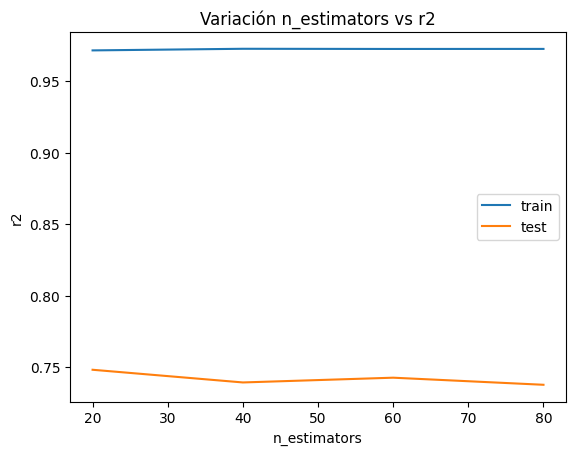

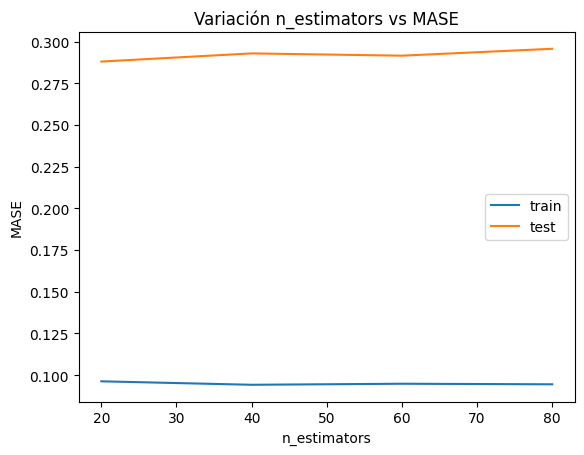

--------------------------------------------------

Ajustando para max_depth=2
Ajustando para max_depth=4
Ajustando para max_depth=6
Ajustando para max_depth=8
Ajustando para max_depth=10
Ajustando para max_depth=12
Ajustando para max_depth=14


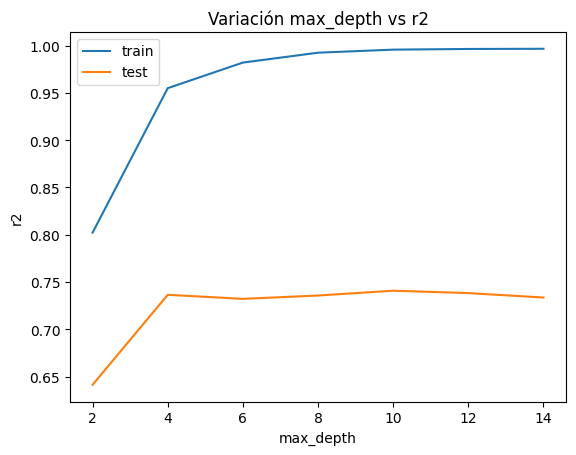

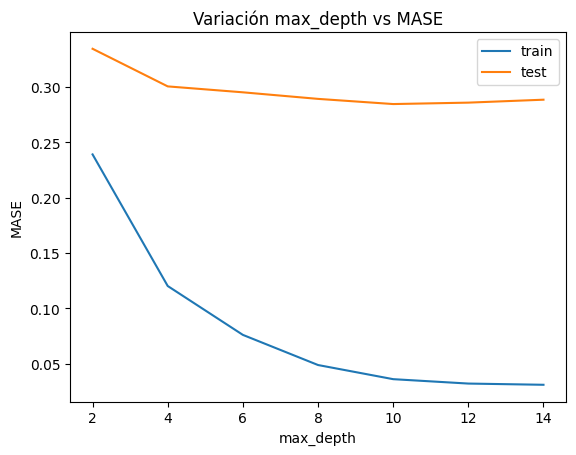

--------------------------------------------------

Ajustando para max_features=2
Ajustando para max_features=4
Ajustando para max_features=6
Ajustando para max_features=8
Ajustando para max_features=10
Ajustando para max_features=12
Ajustando para max_features=14


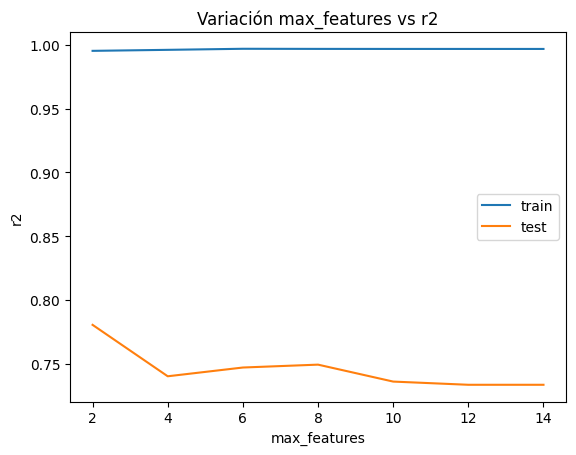

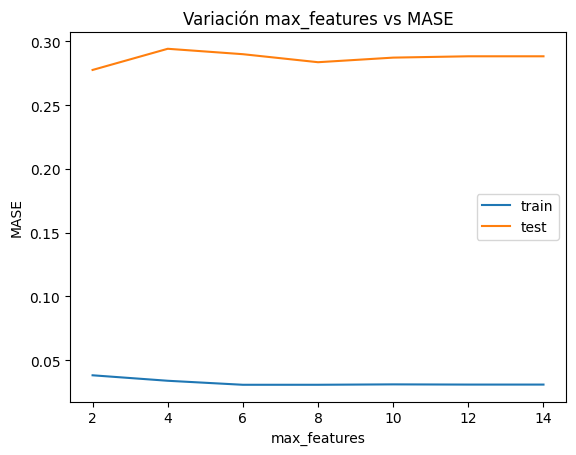

--------------------------------------------------



In [237]:
# Definir rangos de búsqueda para cada parámetro
rfr_search_ranges = {
    "n_estimators": np.arange(20, 100, 20),
    "max_depth": np.arange(2, 16, 2),
    "max_features": np.arange(2, 16, 2),
}

# Definir parámetros base del modelo
rfr_base_params = {"random_state": 4321, "bootstrap": True, "max_depth": 5}

# Búsqueda de parámetros
for param, search_range in rfr_search_ranges.items():
    r2_scores_rfr, mase_scores_rfr = search_param(
        RandomForestRegressor(),
        X_train,
        y_train,
        X_test,
        y_test,
        rfr_base_params,
        param,
        search_range,
    )
    plot_param_perf(
        search_range, r2_scores_rfr, f"Variación {param} vs r2", param, "r2"
    )
    plot_param_perf(
        search_range, mase_scores_rfr, f"Variación {param} vs MASE", param, "MASE"
    )
    print("-" * 50 + "\n")

In [238]:
# Definición de búsqueda de parámetros
hyper_params = {
    "n_estimators": [10, 20, 30],
    "max_depth": [5, 6, 7],
    "max_features": [7, 8, 9],
}
# Inicialización del objeto del modelo
rfr = RandomForestRegressor(**rfr_base_params)


# TimeSeriesSplit respeta el orden temporal de los datos, permite evitar 
# el "look-ahead bias" (usar información futura para predecir el pasado).
tscv = TimeSeriesSplit(
                        n_splits=5, # Número de divisiones (splits) a realizar en los datos
                        gap=24)     # Los registros estan dados en horas, entonces se omiten 24 observaciones (1 dia)
                                    # entre el conjunto de entrenamiento y el conjunto de prueba. Permite asegurarse 
                                    # que los datos utilizados para entrenar un modelo de series temporales no incluyan 
                                    # información futura que podría influir en los resultados del modelo. 
                                    # Esto es crucial para mantener la integridad y la validez de los pronósticos

# Grid Search
grid_search_rfr = GridSearchCV(
    estimator=rfr,
    param_grid=hyper_params,
    cv=tscv,
    scoring="r2",
    verbose=1,
    n_jobs=-1,
)
grid_search_rfr.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=TimeSeriesSplit(gap=24, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(max_depth=np.int64(14),
                                             max_features=np.int64(14),
                                             n_estimators=np.int64(80),
                                             random_state=4321),
             n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7], 'max_features': [7, 8, 9],
                         'n_estimators': [10, 20, 30]},
             scoring='r2', verbose=1)

In [239]:
resultados = pd.DataFrame(grid_search_rfr.cv_results_)
resultados.filter(regex="(param.*|mean_t|std_t|mean_f)").drop(
    columns="params"
).sort_values(["mean_test_score", "mean_fit_time"], ascending=False).head(5)

,mean_fit_time,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score
13,0.0351,6,8,20,0.9032,0.0448
14,0.0475,6,8,30,0.8996,0.0508
20,0.0488,7,7,30,0.8958,0.0597
19,0.0347,7,7,20,0.8947,0.0617
17,0.0535,6,9,30,0.8930,0.0639


In [240]:
# Resultados promedio de r2 score en cada pliegue del mejor estimador
pd.DataFrame(grid_search_rfr.cv_results_).filter(regex="split.*_test_score").loc[
    grid_search_rfr.best_index_
]

split0_test_score   0.8167
split1_test_score   0.9155
split2_test_score   0.9361
split3_test_score   0.9396
split4_test_score   0.9081
Name: 13, dtype: float64

In [241]:
# Escoger el mejor Random Forest
best_rfr = grid_search_rfr.best_estimator_

best_rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, max_features=8, n_estimators=20,
                      random_state=4321)

In [242]:
# Evaluación en datos de entrenamiento
y_train_pred = best_rfr.predict(X_train)
print(f"Train R2: {r2_score(y_train, y_train_pred):.4f}")
print(
    f"Train MASE: {mean_absolute_scaled_error(y_train, y_train_pred, y_train=y_train):.4f} \n"
)


# Evaluación en datos de prueba
y_test_pred = best_rfr.predict(X_test)
print(f"Test R2: {r2_score(y_test, y_test_pred):.4f}")
print(
    f"Test MASE: {mean_absolute_scaled_error(y_test, y_test_pred, y_train=y_test):.4f}"
)

Train R2: 0.9820
Train MASE: 0.0762 

Test R2: 0.7318
Test MASE: 0.2933


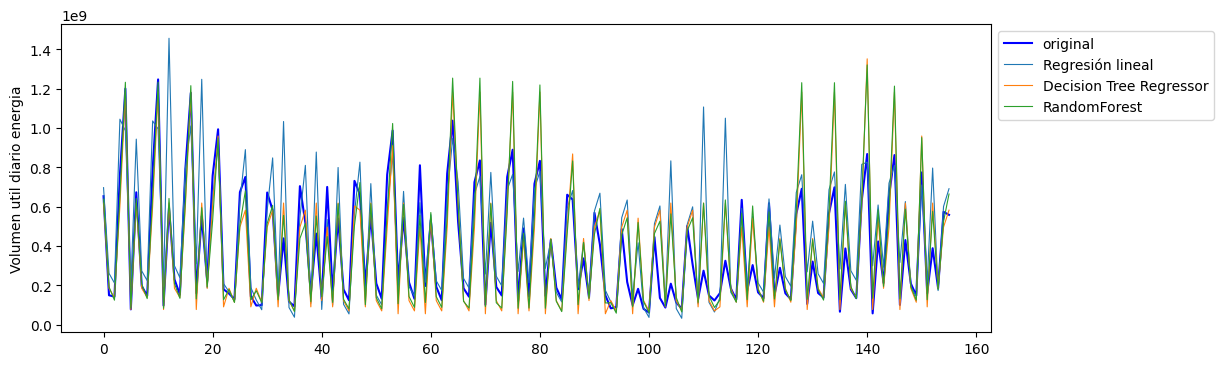

In [243]:
# Rangos de registros a visualizar
start =0
end = 300

# Resultados en los datos de prueba para los mejores modelos
predictions = {
    "Regresión lineal": lr.predict(X_test),
    "Decision Tree Regressor": dtr.predict(X_test),
    "RandomForest": best_rfr.predict(X_test)
}

# Crear DataFrame para la comparación de los modelos
ts_df = pd.DataFrame({"Volumen util diario energia": y_test.values})
ts_df = ts_df.assign(**{f"Valor predecido de Volumen util diario energia {name}": pred for name, pred in predictions.items()})


# Función para graficar un rango de tiempo específico
#def plot_time_range(ts_df, start, end):
plt.figure(figsize=(12, 4))  # Ajusta el tamaño de la figura

# Graficar una ventana de tiempo de los datos de prueba junto con los resultados de los mejores modelos
sns.lineplot(data=ts_df["Volumen util diario energia"][start:end], color="blue", label="original")
for name in predictions.keys():
    sns.lineplot(data=ts_df[f"Valor predecido de Volumen util diario energia {name}"][start:end], label=name, linewidth=0.8)

plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [198]:
# Separación de variables de entrada y variable de salida
Xp = data_prueba.drop(columns=["VolumenUtilDiarioEnergia"])
yp = data_prueba["VolumenUtilDiarioEnergia"]

In [244]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)
print(Xp)

# Escalado de datos
Xp_scaled = scaler.transform(Xp)

## Convertir a dataframes
Xp_scaled = pd.DataFrame(Xp_scaled, columns=Xp.columns)

        ONI     SST  CapacidadUtilEnergia  VertimientosEnergia  month  year  \
838 -0.1100 26.8500            1449344766        44468480.0000      8  2024   
25  -0.3600 27.4700             235260926               0.0000      5  2013   
872 -0.3900 26.4800             162348906               0.0000      2  2025   
171  0.9300 28.7600            3992426064               0.0000      5  2015   
825  0.1500 27.8000            3991980321               0.0000      6  2024   
..      ...     ...                   ...                  ...    ...   ...   
804  1.1400 28.4300            4120467066             872.6852      3  2024   
255 -0.3600 26.9300            3992426064        70981667.2223      7  2016   
867 -0.5900 26.0500            3992069970               0.0000      1  2025   
694 -0.9100 26.0400            2072124857       511727136.8050      8  2022   
351 -0.8400 25.8400            3775528357               0.0000     11  2017   

     RegionHidrologica_Caldas  RegionHidrologica_Ca

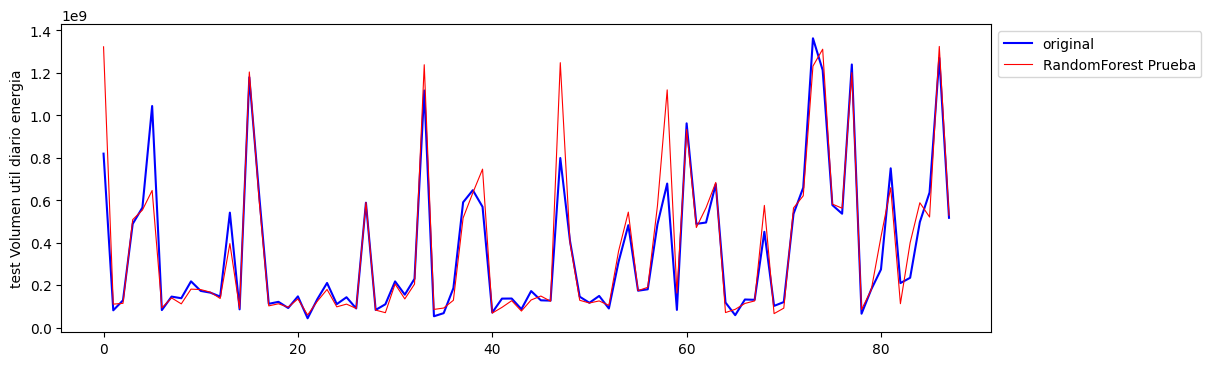

In [245]:
# Rangos de registros a visualizar
start =0
end = 150

# Resultados en los datos de prueba para el mejor modelo
predictions = {
    "RandomForest Prueba": best_rfr.predict(Xp_scaled)
}

# Crear DataFrame para la comparación de los modelos
ts_df = pd.DataFrame({"test Volumen util diario energia": yp.values})
ts_df = ts_df.assign(**{f"predicted Volumen util diario energia {name}": pred for name, pred in predictions.items()})


# Función para graficar un rango de tiempo específico
#def plot_time_range(ts_df, start, end):
plt.figure(figsize=(12, 4))  # Ajusta el tamaño de la figura

# Graficar una ventana de tiempo de los datos de prueba junto con los resultados de los mejores modelos
sns.lineplot(data=ts_df["test Volumen util diario energia"][start:end], color="blue", label="original")
for name in predictions.keys():
    sns.lineplot(data=ts_df[f"predicted Volumen util diario energia {name}"][start:end], label=name, color="red", linewidth=0.8)

plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [246]:
# Evaluación en datos de entrenamiento
y_train_pred = best_rfr.predict(X_train)
print(f"Train R2: {r2_score(y_train, y_train_pred):.4f}")
print(
    f"Train MASE: {mean_absolute_scaled_error(y_train, y_train_pred, y_train=y_train):.4f} \n"
)

# Evaluación en datos de prueba
y_pred_rfr = best_rfr.predict(Xp_scaled)
print(f"Prueba R2: {r2_score(yp, y_pred_rfr):.4f}")
print(
    f"Prueba MASE: {mean_absolute_scaled_error(yp, y_pred_rfr, y_train=yp):.4f}"
)

Train R2: 0.9820
Train MASE: 0.0762 

Prueba R2: 0.8904
Prueba MASE: 0.2022


In [247]:
# Convertir la lista de predicciones a un DataFrame
df_predicciones = pd.DataFrame(best_rfr.predict(Xp_scaled), columns=['predicted_traffic_volume'], index=data_prueba.index)

# Unir dfPrueba con df_predicciones
df_resultado = pd.concat([data_prueba, df_predicciones], axis=1)

# Agregar una columna de error con la diferencia entre el valor real y el pronosticado
df_resultado['error'] = df_resultado['VolumenUtilDiarioEnergia'] - df_resultado['predicted_traffic_volume']

# Calcular el error absoluto
df_resultado['absolute_error'] = df_resultado['error'].abs()

# Calcular el error promedio del valor absoluto
error_promedio_absoluto = df_resultado['absolute_error'].mean()

# Calcular la mediana del valor absoluto del error
mediana_error_absoluto = df_resultado['absolute_error'].median()

print(f"Error promedio absoluto   : {error_promedio_absoluto}")
print(f"Mediana del error absoluto: {mediana_error_absoluto}")

Error promedio absoluto   : 56331510.94781604
Mediana del error absoluto: 24952805.22361353


<h1 align="center"> <b>Conclusiones:</b></h1>

1. **Importancia del modelo Random Forest:** El modelo Random Forest mostró un desempeño superior en comparación con otros modelos como la regresión lineal y el árbol de decisión, obteniendo un R² de 0.8904 en los datos de prueba y un MASE de 0.2022, lo que indica una buena capacidad predictiva para el volumen útil diario de energía.


2. **Impacto de las variables climáticas:** Variables como el índice ONI y la temperatura superficial del mar (SST) demostraron ser relevantes para predecir el volumen útil diario de energía, destacando la influencia de factores climáticos en las reservas hidráulicas.

3. **Importancia de la región hidrológica:** La inclusión de variables categóricas relacionadas con las regiones hidrológicas, transformadas en variables dummy, permitió capturar diferencias regionales significativas en el comportamiento del volumen útil diario de energía.

5. **Optimización de hiperparámetros:** La búsqueda de hiperparámetros mediante GridSearchCV y TimeSeriesSplit fue clave para ajustar el modelo Random Forest, logrando un equilibrio entre complejidad y desempeño, con parámetros óptimos como `max_depth=6`, `n_estimators20` y `max_features=8`.
